<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/LLM%20MedBERT%20NER%20speech%20to%20text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import librosa
import numpy as np
import soundfile as sf
from scipy.io import wavfile
from IPython.display import Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [34]:
#tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")

voice_model = "bond005/wav2vec2-large-ru-golos"

tokenizer = Wav2Vec2Tokenizer.from_pretrained(voice_model)
model = Wav2Vec2ForCTC.from_pretrained(voice_model)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


In [37]:
file_name = 'example_voice.wav'
Audio(file_name)

In [38]:
data = wavfile.read(file_name)
framerate = data[0]
sounddata = data[1]
time = np.arange(0,len(sounddata))/framerate
input_audio, _ = librosa.load(file_name, sr=16000)
input_values = tokenizer(input_audio, return_tensors="pt").input_values
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)[0]
transcription

'я пожилую человек живу недалеко вот метро соколо живу в москве принимаю анельгин не вролок сказал мне что у меня эпилепсия нескреека месяцев  испытывую судороге'

(1177536,) 48000


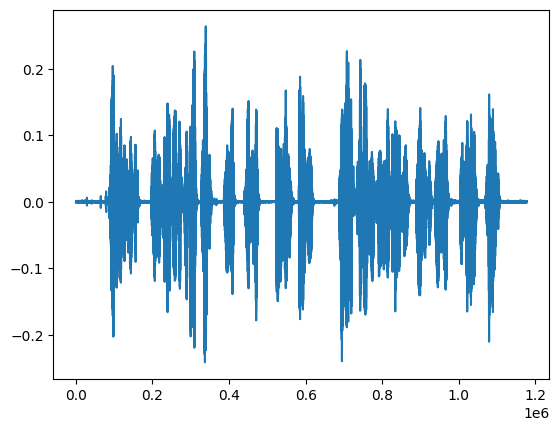

In [39]:
import matplotlib.pyplot as plt
import soundfile as sf

data, fs = sf.read(file_name)
print(data.shape,fs)

plt.plot(data)
plt.show()

## NER ruBERT MED finetuned


In [40]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

In [21]:
#BASE_MODEL = "Open-Orca/Mistral-7B-SlimOrca"
BASE_MODEL = "Mykes/rubert_ner_SDDCS"
#BASE_MODEL = "cointegrated/rubert-tiny2"

В контексте модели Mistral или других языковых моделей (LLM), adapter_model — это дополнительный модуль или слой, который можно "подключить" к основной модели для адаптации её под конкретные задачи или домены без необходимости полного переобучения модели.

Что такое адаптеры?

Адаптеры — это небольшие, легковесные модули, которые добавляются к слоям основной модели. Они обучаются на специфических данных, позволяя модели лучше справляться с конкретными задачами (например, классификация текста, перевод, анализ тональности и т.д.), при этом основная модель остаётся неизменной. Это особенно полезно, когда у вас ограничены вычислительные ресурсы или данные для полного переобучения модели.

offload_folder - нужен предотвращения ошибки переполнения дискового места окружения.

In [22]:
import os
from huggingface_hub import login
from google.colab import userdata

os.environ["HF_token"] = userdata.get("HF_token")

login(os.environ["HF_token"])

Тонкая настройка больших предварительно обученных моделей часто оказывается слишком затратной из-за их масштаба. Методы эффективной тонкой настройки параметров (Parameter-Efficient Fine-Tuning, PEFT) позволяют эффективно адаптировать большие предварительно обученные модели к различным прикладным задачам путем тонкой настройки лишь небольшого количества дополнительных параметров модели вместо всех её параметров. Это значительно снижает вычислительные и стоимостные затраты. Современные передовые методы PEFT демонстрируют результаты, сопоставимые с полностью дообученными моделями.

PEFT интегрирован с библиотеками Transformers для упрощения обучения и вывода моделей, Diffusers для удобного управления различными адаптерами и Accelerate для распределенного обучения и вывода при работе с действительно большими моделями.

In [23]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Mykes/rubert_ner_SDDCS")
model = AutoModelForTokenClassification.from_pretrained("Mykes/rubert_ner_SDDCS")
model.eval()

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12,

aggregation_strategy


> Add blockquote
                - "none" : Will simply not do any aggregation and simply return raw results from the model

                - "simple" : Will attempt to group entities following the default schema. (A, B-TAG), (B, I-TAG), (C,
                  I-TAG), (D, B-TAG2) (E, B-TAG2) will end up being [{"word": ABC, "entity": "TAG"}, {"word": "D",
                  "entity": "TAG2"}, {"word": "E", "entity": "TAG2"}] Notice that two consecutive B tags will end up as
                  different entities. On word based languages, we might end up splitting words undesirably : Imagine
                  Microsoft being tagged as [{"word": "Micro", "entity": "ENTERPRISE"}, {"word": "soft", "entity":
                  "NAME"}]. Look for FIRST, MAX, AVERAGE for ways to mitigate that and disambiguate words (on languages
                  that support that meaning, which is basically tokens separated by a space). These mitigations will
                  only work on real words, "New york" might still be tagged with two different entities.

                - "first" : (works only on word based models) Will use the :obj:`SIMPLE` strategy except that words,
                  cannot end up with different tags. Words will simply use the tag of the first token of the word when
                  there is ambiguity.

                - "average" : (works only on word based models) Will use the :obj:`SIMPLE` strategy except that words,
                  cannot end up with different tags. scores will be averaged first across tokens, and then the maximum
                  label is applied.
                  
                - "max" : (works only on word based models) Will use the :obj:`SIMPLE` strategy except that words,
                  cannot end up with different tags. Word entity will simply be the token with the maximum score.




In [41]:
from transformers import pipeline

pipe = pipeline(task="ner", model='Mykes/rubert_ner_SDDCS', tokenizer='Mykes/rubert_ner_SDDCS', aggregation_strategy="average")
# I made the misspelled words on purpose
#query = "У ребенка треога и норушения сна, потеря сознания, раньше ставили паническое расстройство. Подскажи психиатра в районе метро Октбрьской."

query = transcription
#query = "Доктор, у женщины уже несколько месяцев случаются судороги, которые очень пугают меня и окружающих. Обычно всё начинается c внезапной потери сознания и начинаю судорожно дергаться. Предварительно невролог мне сказал, что это эпилеписия. Я принимала анальгин, но мне необходимо что-то другое? Что вы можете посоветовать купить, я пожилой человек, живу в Москве недалеко от метро cокол"

pipe(query.lower())

Device set to use cpu


[{'entity_group': 'AGE',
  'score': 0.9423933,
  'word': 'пожилую',
  'start': 2,
  'end': 9},
 {'entity_group': 'SUBWAY',
  'score': 0.9985645,
  'word': 'соколо',
  'start': 42,
  'end': 48},
 {'entity_group': 'CITY',
  'score': 0.99987173,
  'word': 'москве',
  'start': 56,
  'end': 62},
 {'entity_group': 'DRUG',
  'score': 0.9858703,
  'word': 'анельгин',
  'start': 72,
  'end': 80},
 {'entity_group': 'DISEASE',
  'score': 0.9997084,
  'word': 'эпилепсия',
  'start': 113,
  'end': 122}]

In [42]:
import spacy
from spacy import displacy

def convert_to_displacy_format(text, ner_results):
    entities = []
    for result in ner_results:
        # Convert the Hugging Face output into the format displacy expects
        entities.append({
            "start": result['start'],
            "end": result['end'],
            "label": result['entity_group']
        })
    return {
        "text": text,
        "ents": entities,
        "title": None
    }
#query = "У ребенка треога и норушения сна, потеря сознания, раньше ставили паническое расстройство, принимал атаракс. Подскажи хорошего психиатра в районе метро Октбрьской."
ner_results = pipe(query.lower())
displacy_data = convert_to_displacy_format(query, ner_results)
colors = {
    "SPECIALITY": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "CITY": "linear-gradient(90deg, #feca57, #ff9f43)",
    "DRUG": "linear-gradient(90deg, #55efc4, #81ecec)",
    "DISEASE": "linear-gradient(90deg, #fab1a0, #ff7675)",
    "SUBWAY": "linear-gradient(90deg, #00add0, #0039a6)",
    "AGE": "linear-gradient(90deg, #44def2, #90e9f5)",
    "SYMPTOM": "linear-gradient(90deg, #e74c3c, #c0392b)",
    "GENDER": "linear-gradient(90deg, #2bc0b9, #2bc03a)"
}
options = {"ents": ["SPECIALITY", "CITY", "DRUG", "DISEASE", "SYMPTOM", "AGE", "SUBWAY", "GENDER"], "colors": colors}
html = displacy.render(displacy_data, style="ent", manual=True, options=options, jupyter=False)
with open("ner_visualization_with_colors.html", "w", encoding="utf-8") as f:
    f.write(html)
from IPython.display import display, HTML
display(HTML(html))

Named Entity Recognition (NER) model based on the cointegrated/rubert-tiny2 model with only 29.4M params, designed to detect russian medical entities like diseases, drugs, symptoms